In [3]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from skimage import color

In [6]:
trainset=load_trainset('../stl-10/')

Files already downloaded and verified


  0%|                                                                | 245760/2640397119 [00:20<15:26:37, 47487.17it/s]

In [33]:
for i in tqdm(range(len(trainset.data))):
    Image.fromarray(trainset.data[i]).save('stl-10/test/stl_%06d.png'%i)

In [5]:
trainset=STL('stl-10/')

In [28]:
AB=[]

In [30]:
order=np.random.permutation(len(trainset))
for i in tqdm(range(len(trainset))):
    AB.extend(ab2bins(color.rgb2lab(trainset[order[i]].numpy().transpose((1,2,0)))[:,:,1:]).flatten().tolist())

KeyboardInterrupt: 

In [31]:
len(AB)

6064128

In [35]:
bins=nbins.copy()


array([[[0.54339633, 0.33479347, 0.94912913]]])

Text(0, 0.5, 'b')

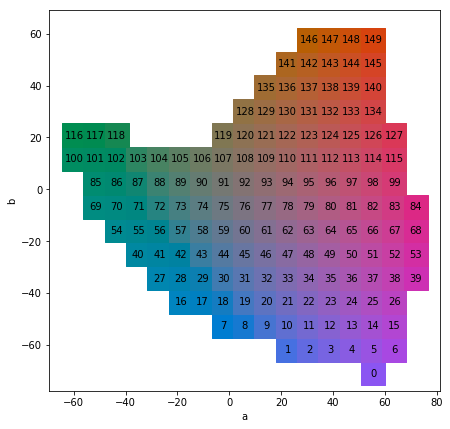

In [77]:
plt.figure(figsize=(7,7))
for i in range(len(bins[0])):
    c=color.lab2rgb(np.array([50,*bins[0,i]])[None,None,:])[0,0]
    plt.scatter(*bins[0,i].T,marker='s',s=600,color=c)
    plt.text(*bins[0,i],i,ha='center',va='center')
plt.axis('equal')
plt.xlabel('a')
plt.ylabel('b')
#plt.axes('equal')

In [80]:
weights.argsort()[::-1]

array([ 69,  15,   5,   6,  39,  14,  38,  13,  26,  25,  70,  68, 100,
        84,  54,  24,  53,  36,  52,   4,  12,  35,  51,  37,  50,  49,
       101,  23,  16,  66,  85,  40,  65,  67,  83,  34,  55,  22,  48,
        99,  64,  27, 115,  86,  98,  81,   0, 102,  71,  41,  63,  80,
        97,  82,   3,  28, 114,  11,  87,  47, 148, 116,  79,   2,   7,
       127,  96,  72, 126,   1,  62,  33, 147, 113,  21,  10,  42,  56,
       144,  17, 117, 143, 103,  88,   8, 125,  57,  95, 112, 138, 134,
        78, 142, 149, 139, 133,  29, 145, 140,  20,  46,   9, 132, 124,
        32, 137,  73, 131,  61, 146, 111, 123,  94,  18,  89, 136,  19,
        77,  43, 110, 130, 141, 122,  31,  45,  58,  30, 104,  93, 129,
        74, 135,  60, 109, 118, 121,  44,  90, 105, 106,  59, 128,  76,
       120, 119, 108,  92, 107,  75,  91], dtype=int64)

In [143]:
w=torch.load('resources/class-weights-lab150-stl.pt')#[145]

In [191]:
w[92]=.11

In [171]:
rosa=np.array([229,212,229])[None,None,:]/255
rlab=color.rgb2lab(rosa)
bi=ab2bins(rlab[:,:,1:]).item()
bi,w[bi]

(76, 0.3589464371506111)

In [184]:
w[np.arange(110,116)]#=w[np.arange(62,69)]**.96

array([ 1.61926761,  2.85479488,  5.60069323,  9.4040081 , 17.98226963,
       31.34160101])

In [1]:
from models.color_unet import color_unet

In [4]:
cu=color_unet(True,0,150)
cu.load_state_dict(torch.load('weights/stllabclass7.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [24]:
out=cu(next(iter(trainset))[None,:1,...]).detach().numpy()

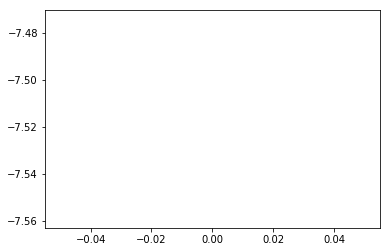

In [87]:
loader=torch.utils.data.DataLoader(trainset)

In [93]:
out=cu(next(iter(loader))[:,:1,:,:])

In [227]:
probdist={k: 0 for k in range(150)} 
for img in tqdm(iter(loader)):
    bis=np.bincount(ab2bins(img[:,1:,:,:].cuda()).cpu().numpy().flatten())
    for i in np.nonzero(bis)[0]:
        probdist[i]+=bis[i]

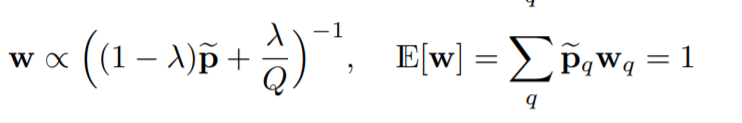

In [228]:
lam=.5
Q=150
p=np.array(list(probdist.values()))
p=p/p.sum()

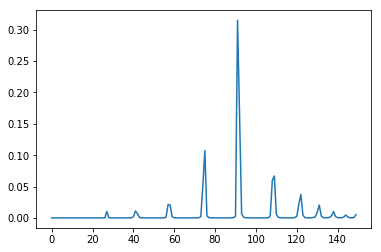

In [231]:
plt.plot(p)

In [232]:
wr=1/((1-lam)*p+lam/Q)

In [246]:
torch.save(wr+w,'resources/class-weights-lab150-stl_alt2.pt')

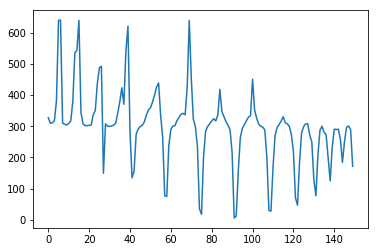

In [245]:
plt.plot(w+wr)
#plt.plot(wr)

In [207]:
np.nonzero(np.bincount(bs))[0]

array([ 57,  58,  59,  60,  73,  74,  75,  76,  77,  79,  90,  91,  92,
        93,  94, 105, 106, 107, 108, 109, 110, 111, 112, 119, 120, 121,
       122, 123, 124, 125, 129, 130, 131, 132, 133, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], dtype=int64)

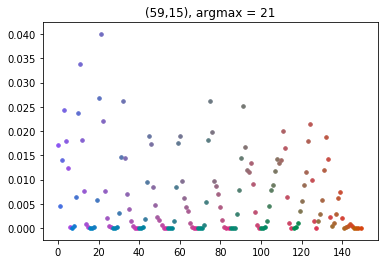

In [156]:
x=np.random.randint(0,96,2)
x,y=x[0],x[1]
prob=out.detach().numpy()[0,:,x,y]
for i in range(len(bins[0])):
    c=color.lab2rgb(np.array([50,*bins[0,i]])[None,None,:])[0,0]
    plt.scatter(i,prob[i].T,marker='.',s=50,color=c)
plt.title('(%i,%i), argmax = %s'%(x,y,prob.argmax()))
    #plt.text(*bins[0,i],i,ha='center',va='center')
plt.show()

In [106]:
ab_from_distr(out.detach())[0]

array([[[ -6.7878532,  -9.250008 ],
        [ -8.355898 , -10.168919 ],
        [ -8.576243 , -12.83814  ],
        ...,
        [-12.7308655,  -6.669756 ],
        [-11.935753 ,  -6.274234 ],
        [ -9.242294 ,  -5.4372654]],

       [[ -8.431533 , -11.585441 ],
        [ -8.649975 , -13.676817 ],
        [ -9.067643 , -15.59267  ],
        ...,
        [-14.343393 ,  -7.140543 ],
        [-13.754498 ,  -7.6505356],
        [-11.999896 ,  -4.995872 ]],

       [[ -8.845657 , -12.635601 ],
        [ -9.588561 , -14.465086 ],
        [-10.108742 , -15.27663  ],
        ...,
        [-14.578299 ,  -8.517374 ],
        [-14.354832 ,  -8.365727 ],
        [-12.508108 ,  -5.8514156]],

       ...,

       [[  4.130398 ,  -3.4699507],
        [  4.0302315,  -2.6943994],
        [  8.788906 ,  -7.835552 ],
        ...,
        [-15.09732  ,  13.676248 ],
        [-16.60746  ,  13.730953 ],
        [-11.124235 ,  12.050375 ]],

       [[  3.0661376,   0.2588371],
        [  2.5007033,  -1.0

In [194]:
w[118]=.05

array([[[77]]], dtype=int64)

In [17]:
from sklearn.utils import class_weight

In [32]:
np.unique(AB).shape

(146,)

In [24]:
weights=class_weight.compute_class_weight('balanced',np.arange(150),AB)

In [16]:
weights=torch.load('resources/class-weights-lab150-stl.pt')

In [22]:
sorted(np.clip(weights**1.1,0,2500))

[0.08356278844786694,
 0.1678156032399931,
 0.21558141187788094,
 0.21994472054266462,
 0.2334807648726726,
 0.23386068969617232,
 0.34010502363183265,
 0.3589464371506111,
 0.38303090820333946,
 0.39670093899693454,
 0.42392787447029295,
 0.5304766097298999,
 0.618776067401482,
 0.641290257792432,
 0.6457335715840165,
 0.6589394023766639,
 0.6679032927409837,
 0.7407719808013131,
 0.7685405509672976,
 0.831555916068237,
 0.8406595002868583,
 0.9381244284686239,
 1.0613968530682423,
 1.0865089767924108,
 1.176557475662064,
 1.201972945810801,
 1.383747046088028,
 1.4606167014183264,
 1.4660881728612558,
 1.5460611201201666,
 1.6192676111303796,
 1.7198914079675085,
 1.809695432024054,
 1.9947535439236017,
 2.0913267119726537,
 2.257717013067561,
 2.480688181756835,
 2.584447286362549,
 2.601767656831926,
 2.854794884239485,
 2.911365755622674,
 3.108347765472298,
 3.1824514359827947,
 3.2703510609240407,
 3.485451169912765,
 3.5746157904126443,
 3.6646028608151564,
 3.8376222182726023,

In [185]:
torch.save(np.clip(weights**1.1,0,2500),'resources/class-weights-lab150-stl.pt')

In [195]:
torch.save(w,'resources/class-weights-lab150-stl.pt')

In [8]:
flag=np.load('resources/labhistogram.npy')

In [17]:
weights

array([2.01456378e+01, 7.97515529e+00, 8.70502766e+00, 1.40571014e+01,
       5.52092106e+01, 2.00000000e+02, 2.00000000e+02, 8.62924854e+00,
       5.47118834e+00, 3.42544536e+00, 7.47860572e+00, 1.32310958e+01,
       5.31026741e+01, 1.43233987e+02, 1.47419917e+02, 2.00000000e+02,
       3.41392690e+01, 7.00128900e+00, 2.28403092e+00, 1.87338305e+00,
       3.44390496e+00, 7.60141772e+00, 2.66640499e+01, 3.53527185e+01,
       8.73257554e+01, 1.16349606e+02, 1.19135862e+02, 2.32606193e+01,
       1.40282865e+01, 3.69369008e+00, 1.07834459e+00, 1.34348669e+00,
       3.18372678e+00, 7.87576450e+00, 2.99980431e+01, 5.29130777e+01,
       7.95645177e+01, 4.78436408e+01, 1.46699622e+02, 1.89896985e+02,
       3.21502004e+01, 1.58603745e+01, 7.43320681e+00, 1.63716270e+00,
       6.67721145e-01, 1.18203827e+00, 3.42892439e+00, 1.07603129e+01,
       2.56416971e+01, 3.65119139e+01, 4.05885982e+01, 5.19465105e+01,
       6.55480109e+01, 8.09981809e+01, 9.03288773e+01, 2.85769578e+01,
      